In [21]:
import datetime
import fnmatch
import matplotlib.cbook
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
import numpy as np
import os
import pandas as pd
import pickle
import platform
from pylab import rcParams
import scipy
from scipy import stats
import warnings

import sessionlists

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
startTimeNotebook = datetime.datetime.now()
if 'COLAB_GPU' in os.environ:
    !git clone https://github.com/HeathenToaster/code
    %cd code
# %run VIGOR_Functions
plt.style.use('./Figures/test.mplstyle')

## Define data path.
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/DATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1oxWJLF67TEifzQFgtUHIyhnEsS6AeQUW
    !unzip -qq /content/code/datacopy.zip
    root="/content/code/datacopy"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

Path to data is: /home/david/Desktop/DATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save


In [6]:
import glob, re, os
import VIGOR_utils as VIGutils
import VIGOR_plotting as VIGplot



# %run VIGOR_utils
# %run VIGOR_plotting
animalList = [os.path.basename(path) for path in sorted(glob.glob(root+"/Rat*"))]
animal = animalList[0]
sessionList = dist60[2:4]
session = 'RatF00_2021_07_19_15_25_33'

p = VIGutils.ProcessData(root, animal, session, buggedSessions, redoMask=False, redoFig=False)

p.params['boundaries']

[50, 19]

In [7]:
<

SyntaxError: invalid syntax (4056019114.py, line 1)

In [8]:

# convert scale, convert i = 0 to 120 --> 60 to-60 which correspnds to the speed to the right (0 to 60) and to the left (0 to -60)
def convert_scale(number):
    old_min = 0
    old_max = 120
    new_max = -60
    new_min = 60
    return int(((number - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min)

# compute mask to separate runs and stays based on speed
def filterspeed(dataPos, dataSpeed, threshold, dist):
    # dissociate runs from non runs, we want a cut off based on animal, speed. How to define this speed? If we plot the speed of the animal in function of the X position in the apparatus, so we can see that there is some blobs of speeds close to 0 and near the extremities of the treadmill, these are the ones that we want to define as non running speeds. With this function we want to compute the area of these points of data (higher density, this technique might not work when animals are not properly trained) in order to differentiate them.
    middle = dist/2
    xmin, xmax = 0, 120  # specify the x and y range of the window that we want to analyse
    ymin, ymax = -60, 60
    position = np.array(dataPos, dtype=float)  # data needs to be transformed to float perform the KDE
    speed = np.array(dataSpeed, dtype=float)
    X, Y = np.mgrid[xmin:xmax:120j, ymin:ymax:120j]  # create 2D grid to compute KDE
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([position, speed])
    kernel = stats.gaussian_kde(values)  # compute KDE, this gives us an estimation of the point density. SLOW
    Z = np.reshape(kernel(positions).T, X.shape)

    # Using the KDE that we just computed, we select the zones that have a density above a certain threshold (after testing 0.0001 seems to work well), which roughly corresponds to the set of data that we want to extract.
    # We loop through the 2D array, if the datapoint is > threshold we get the line (speed limit) and the row (X position in cm). This gives us the speed limit for each part of the
    # treadmill, so basically a zone delimited with speed limits (speed limits can be different in different points of the zone).
    i, j = [], []  # i is the set of speeds (lines) for which we will perform operations, j is the set of positions (rows) for each speed for which we will perform operations
    for line in range(0, len(np.rot90(Z))):
        if len(np.where(np.rot90(Z)[line] > threshold)[0]) > 1:
            i.append(convert_scale(line))
            j.append(np.where(np.rot90(Z)[line] > threshold)[0])

    # create a mask using the zone computed before and combine them. We have two zones (left and right), so we perform the steps on each side, first part is on the left.
    rawMask = np.array([])
    # pos is the array of positions for which the speed of the animal is under the speed limit. "11 [ 7  8  9 10 11]" for instance here the speed limit is 11 cm/s, and is attained between 7 and 11cm on the treadmill.
    # "10 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 105, 106, 107, 108, 109, 110]" when we decrease the speed limit, here 10, we here have 2 zones, one between 4 and 13cm and another between 105 and 110cm.
    # we continue through these speed values (roughly from 11 to 0, then from 0 to -10 in this example)
    for line, pos in zip(i, j):
        if pos[pos < middle].size:
            low = pos[pos < middle][0]  # first value of the array, explained above (7)
            high = pos[pos < middle][-1]  # last value of the array (11)
            a = np.ma.masked_less(position, high)  # take everything left of the rightmost point, if the value is ok == True
            b = np.ma.masked_greater(position, low)  # take everything right of the leftmost point
            c = np.ma.masked_less(speed, line+0.5)  # take everything below the high point
            d = np.ma.masked_greater(speed, line-0.5)  # take everything above the low point
            mask = np.logical_and(a.mask, b.mask)  # first combination for all the rows (=Xposition), keep the intersection of mask a AND b, so keep all between the leftmost and rightmost points
            mask2 = np.logical_and(c.mask, d.mask)  # second combination for all the lines (=speed), keep the intersection of mask c AND d, so keep all between speed+0.5:speed-0.5
            combiLeft = np.logical_and(mask, mask2)  # combine the first and the second mask, so we only keep the intersection of the two masks, intersection is TRUE, the rest is FALSE
            if not rawMask.size:  # must do that for the first iteration so it's not empty
                rawMask = combiLeft
            else:
                rawMask = np.logical_xor(combiLeft, rawMask)  # merge the newly computed mask with the previously computed masks. We use XOR so that the TRUE values of the new mask are added to the complete mask. Same step left and right just add to the existing full mask wether the new mask is on the left or the right.
        # same as above for the right part
        if pos[pos > middle].size:
            low = pos[pos > middle][0]
            high = pos[pos > middle][-1]
            a = np.ma.masked_less(position, high)
            b = np.ma.masked_greater(position, low)
            c = np.ma.masked_less(speed, line + 0.5)
            d = np.ma.masked_greater(speed, line - 0.5)
            mask = np.logical_and(a.mask, b.mask)
            mask2 = np.logical_and(c.mask, d.mask)
            combiRight = np.logical_and(mask, mask2)
            if not rawMask.size:
                rawMask = combiRight
            else:
                rawMask = np.logical_xor(combiRight, rawMask)
    return ~rawMask


In [9]:
dataPos = p.rawPositionX
dataSpeed = p.rawSpeed
threshold = 0.0002
dist = p.params["treadmillDist"]

middle = dist/2
xmin, xmax = 0, 120  # specify the x and y range of the window that we want to analyse
ymin, ymax = -60, 60
position = np.array(dataPos, dtype=float)  # data needs to be transformed to float perform the KDE
speed = np.array(dataSpeed, dtype=float)
X, Y = np.mgrid[xmin:xmax:120j, ymin:ymax:120j]  # create 2D grid to compute KDE
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([position, speed])
kernel = stats.gaussian_kde(values)  # compute KDE, this gives us an estimation of the point density. SLOW
Z = np.reshape(kernel(positions).T, X.shape)

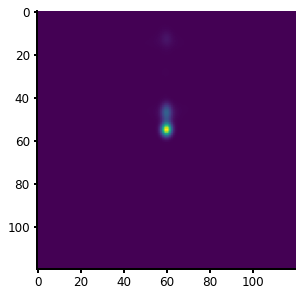

In [10]:
plt.imshow(Z)

In [11]:
mask1 = filterspeed(p.rawPositionX, p.rawSpeed, 0.002, p.params["treadmillDist"])


In [12]:
mask1

array([False, False, False, ..., False, False, False])

In [13]:
p.total_trials

288

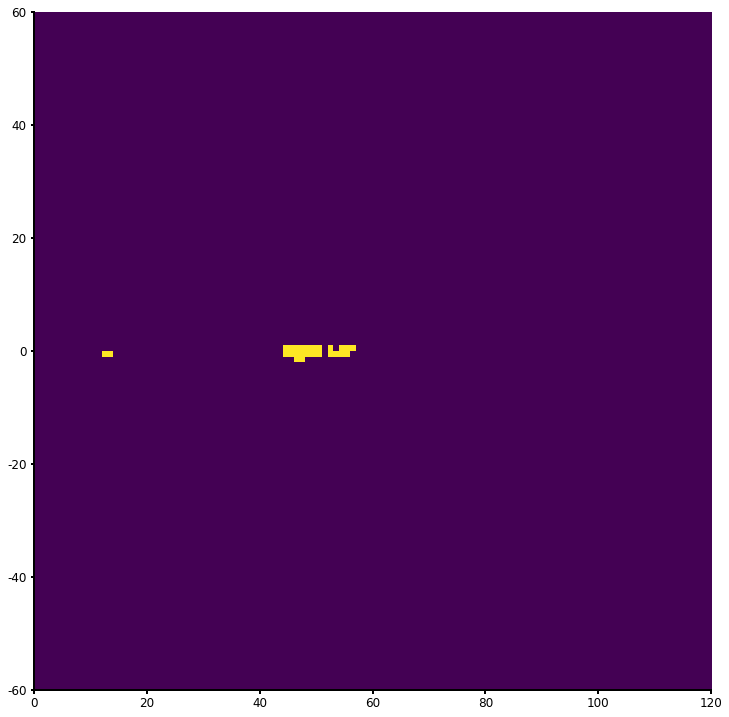

In [14]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt

# Generate some test data
x = p.rawPositionX
y = p.rawSpeed
xbins = np.linspace(0, 120, 121)
ybins = np.linspace(-60, 60, 121)
heatmap, _, __ = np.histogram2d(x, y, bins=(xbins, ybins))

fig, ax = plt.figure(figsize=(10, 10)), plt.gca()
hm = heatmap.T
hm[hm < p.total_trials] = False
hm[hm >= p.total_trials] = True
plt.imshow(hm, extent=[0, 120, -60, 60])#, origin='lower', cmap='jet', aspect='auto', vmax=10000)

In [15]:

# compute mask to separate runs and stays based on speed
def filterspeed2(dataPos, dataSpeed, threshold, dist):
    middle = dist/2
    xmin, xmax = 0, 120  # specify the x and y range of the window that we want to analyse
    ymin, ymax = -60, 60
    position = np.array(dataPos, dtype=float)  # data needs to be transformed to float perform the KDE
    speed = np.array(dataSpeed, dtype=float)

    xbins = np.linspace(xmin, xmax, xmax+1)
    ybins = np.linspace(ymin, ymax, ymax+1)

    heatmap, _, __ = np.histogram2d(dataPos, dataSpeed, bins=(xbins, ybins))

    hm = heatmap.T
    hm[hm < threshold] = False
    hm[hm >= threshold] = True

    mask = np.zeros_like(position, dtype=bool)
    for line in range(ymin , ymax):
        pos = np.where(hm[line] == True)[0]
        if pos[pos < middle].size:
            low = pos[pos < middle][0]
            high = pos[pos < middle][-1]
            a = np.ma.masked_less(position, high)
            b = np.ma.masked_greater(position, low)
            c = np.ma.masked_less(speed, line + 0.5)
            d = np.ma.masked_greater(speed, line - 0.5)
            mask = np.logical_and(a.mask, b.mask)
            mask2 = np.logical_and(c.mask, d.mask)
            combiLeft = np.logical_and(mask, mask2)
            if not mask.size:
                mask = combiLeft
            else:
                mask = np.logical_xor(combiLeft, mask)
        if pos[pos > middle].size:
            low = pos[pos > middle][0]
            high = pos[pos > middle][-1]
            a = np.ma.masked_less(position, high)
            b = np.ma.masked_greater(position, low)
            c = np.ma.masked_less(speed, line + 0.5)
            d = np.ma.masked_greater(speed, line - 0.5)
            mask = np.logical_and(a.mask, b.mask)
            mask2 = np.logical_and(c.mask, d.mask)
            combiRight = np.logical_and(mask, mask2)
            if not mask.size:
                mask = combiRight
            else:
                mask = np.logical_xor(combiRight, mask)
    return ~mask




    # # Using the KDE that we just computed, we select the zones that have a density above a certain threshold (after testing 0.0001 seems to work well), which roughly corresponds to the set of data that we want to extract.
    # # We loop through the 2D array, if the datapoint is > threshold we get the line (speed limit) and the row (X position in cm). This gives us the speed limit for each part of the
    # # treadmill, so basically a zone delimited with speed limits (speed limits can be different in different points of the zone).
    # i, j = [], []  # i is the set of speeds (lines) for which we will perform operations, j is the set of positions (rows) for each speed for which we will perform operations
    # for line in range(0, len(np.rot90(Z))):
    #     if len(np.where(np.rot90(Z)[line] > threshold)[0]) > 1:
    #         i.append(convert_scale(line))
    #         j.append(np.where(np.rot90(Z)[line] > threshold)[0])

    # # create a mask using the zone computed before and combine them. We have two zones (left and right), so we perform the steps on each side, first part is on the left.
    # rawMask = np.array([])
    # # pos is the array of positions for which the speed of the animal is under the speed limit. "11 [ 7  8  9 10 11]" for instance here the speed limit is 11 cm/s, and is attained between 7 and 11cm on the treadmill.
    # # "10 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 105, 106, 107, 108, 109, 110]" when we decrease the speed limit, here 10, we here have 2 zones, one between 4 and 13cm and another between 105 and 110cm.
    # # we continue through these speed values (roughly from 11 to 0, then from 0 to -10 in this example)
    # for line, pos in zip(i, j):
    #     if pos[pos < middle].size:
    #         low = pos[pos < middle][0]  # first value of the array, explained above (7)
    #         high = pos[pos < middle][-1]  # last value of the array (11)
    #         a = np.ma.masked_less(position, high)  # take everything left of the rightmost point, if the value is ok == True
    #         b = np.ma.masked_greater(position, low)  # take everything right of the leftmost point
    #         c = np.ma.masked_less(speed, line+0.5)  # take everything below the high point
    #         d = np.ma.masked_greater(speed, line-0.5)  # take everything above the low point
    #         mask = np.logical_and(a.mask, b.mask)  # first combination for all the rows (=Xposition), keep the intersection of mask a AND b, so keep all between the leftmost and rightmost points
    #         mask2 = np.logical_and(c.mask, d.mask)  # second combination for all the lines (=speed), keep the intersection of mask c AND d, so keep all between speed+0.5:speed-0.5
    #         combiLeft = np.logical_and(mask, mask2)  # combine the first and the second mask, so we only keep the intersection of the two masks, intersection is TRUE, the rest is FALSE
    #         if not rawMask.size:  # must do that for the first iteration so it's not empty
    #             rawMask = combiLeft
    #         else:
    #             rawMask = np.logical_xor(combiLeft, rawMask)  # merge the newly computed mask with the previously computed masks. We use XOR so that the TRUE values of the new mask are added to the complete mask. Same step left and right just add to the existing full mask wether the new mask is on the left or the right.
    #     # same as above for the right part
    #     if pos[pos > middle].size:
    #         low = pos[pos > middle][0]
    #         high = pos[pos > middle][-1]
    #         a = np.ma.masked_less(position, high)
    #         b = np.ma.masked_greater(position, low)
    #         c = np.ma.masked_less(speed, line + 0.5)
    #         d = np.ma.masked_greater(speed, line - 0.5)
    #         mask = np.logical_and(a.mask, b.mask)
    #         mask2 = np.logical_and(c.mask, d.mask)
    #         combiRight = np.logical_and(mask, mask2)
    #         if not rawMask.size:
    #             rawMask = combiRight
    #         else:
    #             rawMask = np.logical_xor(combiRight, rawMask)
    # return ~rawMask
bound = np.min([p.kde(p.leftBoundaryPeak), p.kde(p.rightBoundaryPeak)])*90000/2
mask2 = filterspeed2(p.rawPositionX, p.rawSpeed, bound, p.params["treadmillDist"])

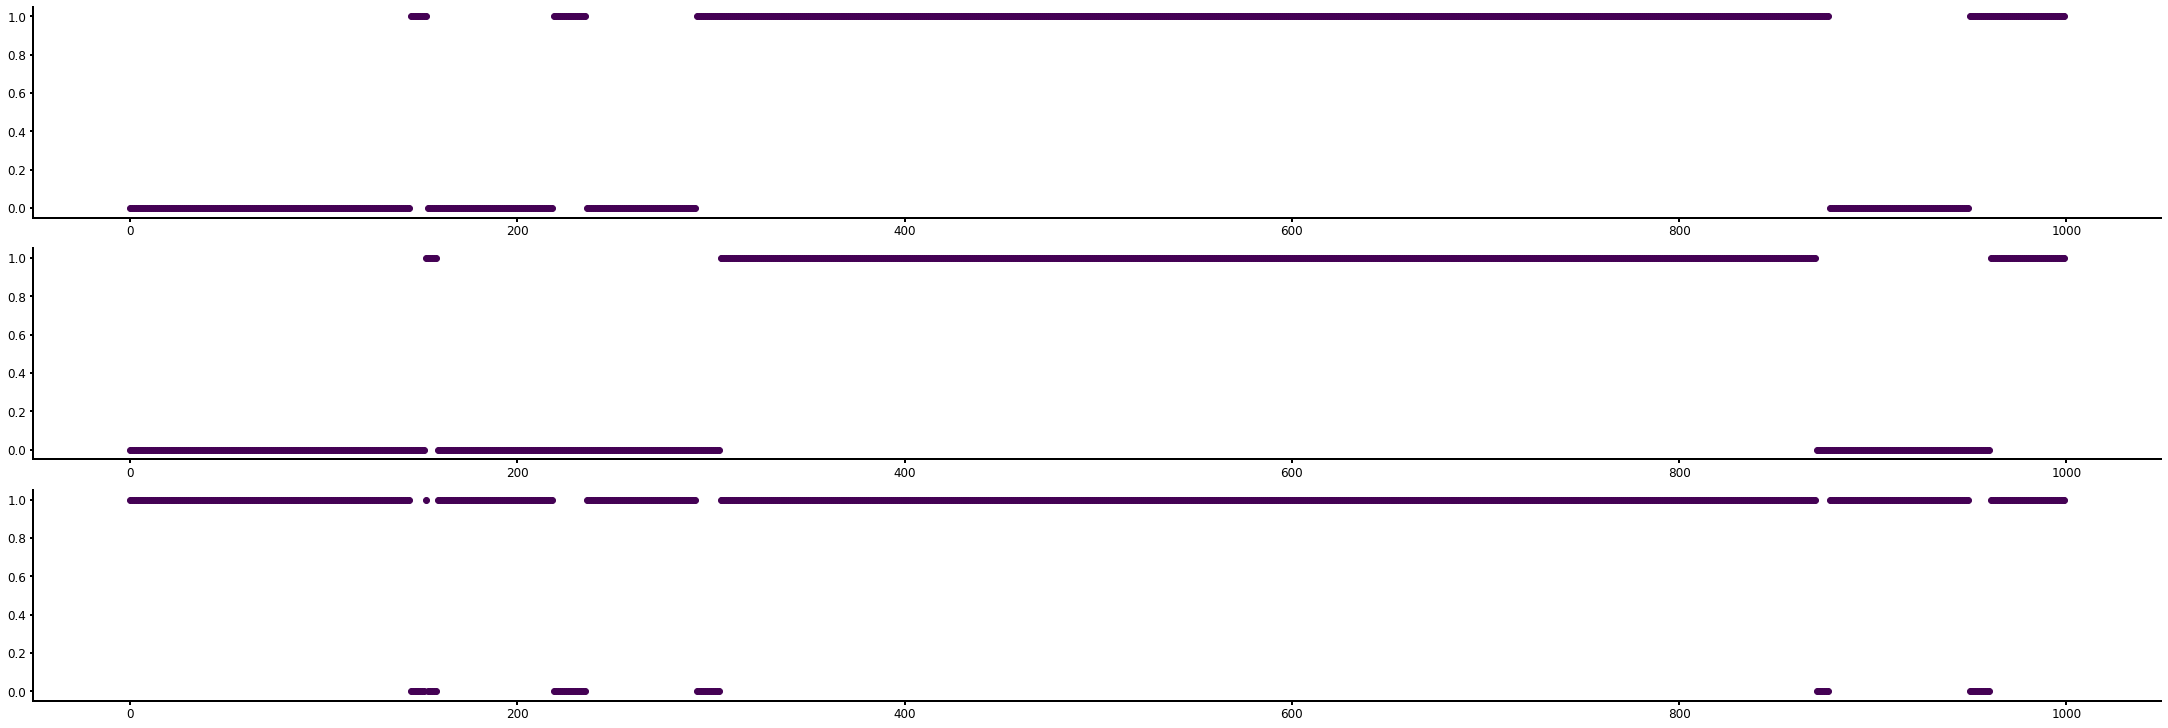

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(30, 10))
for i in range(0, 1000):
    axs[0].scatter(i, mask1[i], c=mask1[i])
    axs[1].scatter(i, mask2[i], c=mask2[i])
    axs[2].scatter(i, mask1[i] == mask2[i], c=mask1[i] == mask2[i])
    # plt.scatter(p.rawPositionX[i], p.rawSpeed[i], c=mask1[i])
# (mask1 == mask2)

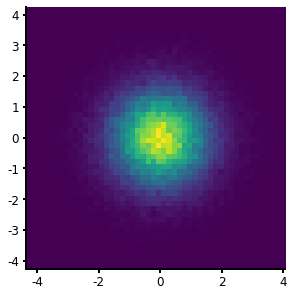

In [17]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt

# Generate some test data
x = np.random.randn(90000)
y = np.random.randn(90000)

heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(heatmap.T, extent=extent, origin='lower')

In [18]:
p.total_trials/90000

0.0032

14 55
[0.01267806] [0.1475711]
[1141.02558134] [13281.39867249]
570.5127906682816


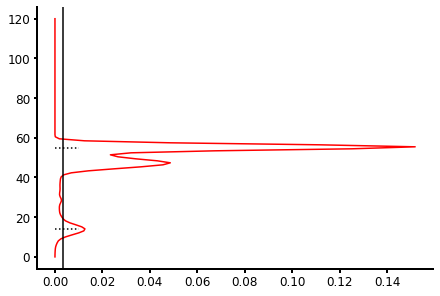

In [19]:
xx = np.linspace(0, 120, 120)
plt.plot(p.kde(xx), xx, color='r')

xline1 = [p.leftBoundaryPeak, p.leftBoundaryPeak]
xline2 = [p.rightBoundaryPeak, p.rightBoundaryPeak]
yline = [0, 0.01]

print(p.leftBoundaryPeak, p.rightBoundaryPeak,)
print(p.kde(p.leftBoundaryPeak), p.kde(p.rightBoundaryPeak))
print(p.kde(p.leftBoundaryPeak)*90000, p.kde(p.rightBoundaryPeak)*90000)

bound = np.min([p.kde(p.leftBoundaryPeak), p.kde(p.rightBoundaryPeak)])*90000/2
print(bound)
plt.axvline(p.total_trials/90000, color='k')
plt.plot(yline, xline1, ":", color='k')
plt.plot(yline, xline2, ":", color='k')

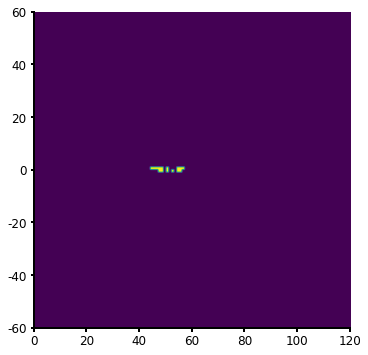

In [20]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt

# Generate some test data
x = p.rawPositionX
y = p.rawSpeed
xbins = np.linspace(0, 120, 121)
ybins = np.linspace(-60, 60, 121)
heatmap, _, __ = np.histogram2d(x, y, bins=(xbins, ybins))

fig, ax = plt.figure(figsize=(5, 5)), plt.gca()
hm = heatmap.T
B = p.total_trials * 4
hm[hm < B] = False
hm[hm >= B] = True
plt.imshow(hm, extent=[0, 120, -60, 60])#, origin='lower', cmap='jet', aspect='auto', vmax=10000)